In [7]:
import sys
sys.path.append('../../scripts/')
#print(sys.path)
"""Process the patch files generated by extractPatches.py and prepare
them for analysis by Kmeans and diffusion-maps"""

from lib.utils import *

from glob import glob
import pickle as pk
from os import system,mkdir
import numpy as np
from os.path import isdir
from minio import Minio

def pad_patch(patch):
    too_big=True
    size=patch.shape[0]
    for sz_block in size_tresholds:
        if size<sz_block:
            too_big=False
            break
    if too_big:
        return None,size

    pad=np.zeros([sz_block,sz_block],dtype=np.float16)
    _from=int((sz_block-size)/2)
    _to = int(sz_block-_from)
    # print(size,sz_block,_from,_to)
    pad[_from:_to,_from:_to]=patch
    return pad,sz_block
    
def extract_vectors():
    Vec_dict={}
    for sz in size_tresholds:
        Vec_dict[sz]=[]
    
    for filename in glob('%s/tiles/*extracted*'%local_data):
        #print('filename=',filename)
        D=pk.load(open(filename,'rb'))
        for e in D:
            patch=np.array(e['normalized_patch'],dtype=np.float16)
            padded,sz=pad_patch(patch)
            if not padded is None:
                Vec_dict[sz].append(padded)
    #return a dict of arrays partitioned according to size.
    return Vec_dict

In [4]:
############################
# read all patch files of a given size and put them in a random order.
############################

# most of the code below is not needed now that we pad the patches when we generate them

root='/Users/yoavfreund/projects/shapeology'
local_data=root+'/data'
exec_dir=root+'/shapeology_code/scripts'
stack='s3://mousebraindata-open/MD657'
size_tresholds=[15,27,51,81,151,201]
files=list_s3_files(stack)
for file in files:
    if 'extracted' in file:
        print(file)
        run('aws s3 cp %s/%s %s'%(stack,file,local_data))
        break

runPipe cmd= aws s3 ls s3://mousebraindata-open/MD657/ 
MD657-N48-2017.02.22-16.41.55_MD657_2_0143_lossless_extracted.tgz
cmd= aws s3 cp s3://mousebraindata-open/MD657/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_lossless_extracted.tgz /Users/yoavfreund/projects/shapeology/data


In [18]:
!tar xzvf $local_data/$file

x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_101.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_102.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_103.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_104.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_105.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_106.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_107.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_108.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_109.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_110.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_111.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_112.thr.pkl
x Users/yoavfreund/projects/shapeology/data/tiles/pickles//tiles_113.thr.pkl

In [24]:
pickle_dir='%s/tiles/pickles'%local_data
!ls $pickle_dir | head

tiles_101.thr.pkl
tiles_102.thr.pkl
tiles_103.thr.pkl
tiles_104.thr.pkl
tiles_105.thr.pkl
tiles_106.thr.pkl
tiles_107.thr.pkl
tiles_108.thr.pkl
tiles_109.thr.pkl
tiles_110.thr.pkl


In [27]:
###############
import pickle as pk
import numpy as np
from glob import glob

for pickle_file in glob(pickle_dir+'/*.pkl'):
    print(pickle_file)
    D=pk.load(open(pickle_file,'rb'))
    break

/Users/yoavfreund/projects/shapeology/data/tiles/pickles/tiles_29.thr.pkl


In [32]:
[x['padded_size'] for x in D]

[15,
 27,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 27,
 15,
 15,
 15,
 15,
 15,
 27,
 27,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 27,
 15,
 51,
 51,
 27,
 81,
 27,
 51,
 51,
 27,
 27,
 51,
 27,
 15,
 15,
 51,
 51,
 51,
 151,
 51,
 15,
 15,
 15,
 151,
 15,
 15,
 15,
 15,
 27,
 27,
 51,
 27,
 27,
 51,
 81,
 27,
 15,
 15,
 151,
 15,
 15,
 81,
 81,
 15,
 15,
 81,
 51,
 27,
 15,
 15,
 27,
 51,
 27,
 15,
 151,
 51,
 81,
 81,
 81,
 51,
 81,
 15,
 27,
 27,
 27,
 15,
 51,
 81,
 81,
 51,
 51,
 27,
 51,
 51,
 51,
 27,
 15,
 15,
 51,
 81,
 51,
 27,
 15,
 27,
 27,
 27,
 51,
 51,
 15]

In [112]:
%%writefile ../../scripts/lib/permute.py
import numpy as np
from numpy.random import permutation

class permutator:
    """ A class that creates a random permutation of equal-size bytearrays"""
    N=0 #number of permutors 
    def __init__(self,element,K=100):  #number of files used for randomization
        assert type(element) == bytearray
        self.nbytes=len(element)
        print(self.nbytes,'bytes per element')
        self.tmpDir='/tmp/permuted-%d'%self.N
        self.K=K
        
        try:
            mkdir(self.tmpDir)
        except:
            print(self.tmpDir,'already exists, moving on.')
        
        self.fp=[]
        for i in range(K):
            self.fp.append(open(self.tmpDir+'/bucket-'+str(i)+'.bin','bw'))

    def push(self,element):
        assert type(element) == bytearray
        if len(element) != self.nbytes:
            throw('Inconsistent element size: init=%d, current=%d'%(self.nbytes,element.nbytes))
        j=np.random.randint(self.K)
        #print(type(element),len(Bytes))
        self.fp[j].write(element)
    
    def combine(self,outfilename):
        # read and permute each file
        for i in range(self.K):
            self.fp[i].close()
            self.fp[i]=open(self.tmpDir+'/bucket-'+str(i)+'.bin','br')
        outfile=open(outfilename,'bw')
        for filename in self.fp:
            D=filename.read()
            #print('buffer length',len(D))
            D=np.frombuffer(D,dtype=np.byte)
            #print(D.shape,type(D[0]))
            elements=D.reshape([-1,self.nbytes])
            #print(elements.shape)

            L=elements.shape[0]
            _order=permutation(L)
            permuted_elements=elements[_order,:]
            permuted_elements.tofile(outfile)
            error=elements.nbytes % self.nbytes
            if error!=0:
                throw('incorrect file size:',filename,'shape=',elements.nbytes,'self.nbytes=',self.nbytes,'error=',error)


Writing ../../scripts/lib/permute.py


In [89]:
x=np.arange(0,1000000,dtype=np.integer)
x.shape

(1000000,)

In [92]:
type(bytearray(x[0].tobytes()))

bytearray

In [103]:
Perm=permutator(bytearray(x[0].tobytes()),K=10)

8 bytes per element
/tmp/permuted-0 already exists, moving on.


In [104]:
%%time
for i in range(x.shape[0]):
    Perm.push(bytearray(x[i].tobytes()))


CPU times: user 2.93 s, sys: 19.3 ms, total: 2.95 s
Wall time: 2.95 s


In [105]:
%%time
!rm permutedNumbers
Perm.combine('permutedNumbers')

CPU times: user 39.8 ms, sys: 40.4 ms, total: 80.3 ms
Wall time: 199 ms


In [106]:
Y=np.fromfile(open('permutedNumbers','br'),dtype=np.integer)

In [107]:
type(Y[0]), len(Y), type(x[0]), len(x)

(numpy.int64, 1000000, numpy.int64, 1000000)

In [108]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [109]:
Z=sorted(Y)

In [110]:
Z[1000:1010]

[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]

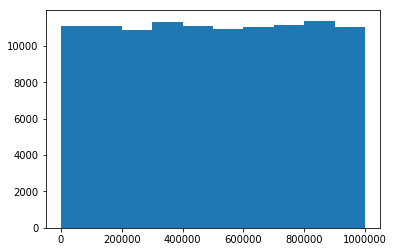

In [111]:
hist(Y[::9]);

In [ ]:
    
for _size in [15,27,81,151,201]:
    permuted_dir=data_dir+'/permuted-%s'%(_size)
    !rm -rf $permuted_dir
    !mkdir $permuted_dir
    !ls $permuted_dir
    stem=permuted_dir+'/permuted'
    print(stem)

    fp=[]
    for i in range(K):
        fp.append(open(stem+str(i)+'.bin','bw'))


    patches=np.zeros([0])
    k=0
    for filename in glob(data_dir+'/*.pkl'):
        print(filename)
        pkl_file=open(filename,'br')
        try:
            V=pk.load(pkl_file)
        except:
            print('could not load',filename)
            continue
        print(V[_size].shape)
        patches=V[_size]

        for i in range(patches.shape[0]):
            j=np.random.randint(K)
            patch=np.array(patches[i,:,:],dtype=np.float16)
            patch.tofile(fp[j])
            if i%1000==0:
                print('\r',filename,i,end='')

        print('finished',k,filename,patches.shape)
        k+=1
        #!rm $filename

    print('finished it all!!')
    for handle in fp:
        handle.close()

    !ls -lrth $permuted_dir | wc

    # read and permute each file
    for filename in glob(permuted_dir+'/*.bin'):

        D=fromfile(filename,dtype=np.float16) #,count=_size*_size)
        pics=D.reshape([-1,_size,_size])

        L=D.shape[0]
        _order=permutation(pics.shape[0])
        permuted_pics=pics[_order,:,:]
        permuted_pics.tofile(filename)
        _s=pics.shape
        error=L - (_s[0]*_s[1]*_s[2])
        print(filename,'shape=',pics.shape,'error=',error)

    tar_filename=data_dir+'/permuted-%d'%_size+'.tgz'

    !tar czvf $tar_filename $permuted_dir/

    #write file to s3
    !aws s3 mv $tar_filename s3://mousebraindata-open/MD657/permuted/

    !rm -rf $permuted_dir

In [37]:
D[0]['padded_patch'].nbytes

450